# **1. Dataset Preparation**

## Target Definition

The machine learning component of this project focuses on predicting appointment attendance failure. We define attendance failure as any scheduled appointment in which the patient ultimately did not appear for care. The status field in the appointments table indicates whether each visit was completed, canceled in advance, or marked as a no-show. For modeling purposes, we grouped cancellations and no-shows together. Both outcomes represent appointments in which clinical resources were reserved but ultimately unused. This allows us to capture the full operational impact of missed visits.

We converted the status field into the following binary target variable:

    1 = Attendance failure (no-show or canceled)
    0 = Completed visit

This formulation structures the task as a supervised binary classification problem. It enables the model to learn patterns associated with missed appointments using historical appointment-level data.
From an operational perspective, predicting attendance failures is highly relevant in healthcare settings. Both no-shows and cancellations reduce provider productivity and disrupt scheduling efficiency. They also complicate capacity planning and increase variability in clinic workflows. Additionally, attendance failures extend patient wait times and negatively affect continuity of care.

Financially, attendance failures generate revenue loss. This occurs because clinical resources—staff time, exam rooms, and operational overhead—must still be reserved regardless of whether the patient attends. Early identification of high-risk appointments enables targeted interventions. These interventions may include automated reminders, personalized outreach, or optimized overbooking strategies to reduce scheduling volatility.
Also, prior research emphasizes the significant operational burden associated with missed appointments. Outpatient attendance failure rates, including both cancellations and no-shows, commonly range between 10% and 30% across clinical settings. These failures contribute to efficiency losses and increased care delivery costs (Dantas et al., 2018; Machado et al., 2021).

###References

Dantas, L. F., Fleck, J. L., Cyrino Oliveira, F. L., & Hamacher, S. (2018). No-shows in appointment scheduling – A systematic literature review. Health Policy, 122(4), 412–421. https://doi.org/10.1016/j.healthpol.2018.02.002


Machado, R. L., Navajas, J., & Coelho, F. (2021). Predicting patient no-shows in medical appointments: A review. Informatics in Medicine Unlocked, 23, 100545. https://doi.org/10.1016/j.imu.2021.100545

## Forming ML model needed dataset

In [ ]:
import sqlite3
import pandas as pd

In [ ]:
conn = sqlite3.connect("healthcare.db")

In [ ]:
tables = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table';",
    conn
)
print(tables)

            name
0       patients
1        doctors
2     procedures
3   appointments
4  prescriptions
5       invoices


In [ ]:
sql_query = """
WITH base AS (
    SELECT
        a.appointment_id,
        a.patient_id,
        a.doctor_id,
        a.appointment_datetime,
        a.reason_for_visit,

        -- target: 1 = attendance failure (no_show or canceled), 0 = completed
        CASE
            WHEN LOWER(a.status) IN ('no_show', 'canceled') THEN 1
            ELSE 0
        END AS attendance_failure,

        -- datetime features
        strftime('%H', a.appointment_datetime) AS appointment_hour,
        strftime('%w', a.appointment_datetime) AS appointment_weekday
    FROM appointments a
),

patient_info AS (
    SELECT
        patient_id,
        gender,
        city,
        (strftime('%Y','now') - strftime('%Y', birthdate)) AS age
    FROM patients
),

history AS (
    SELECT
        patient_id,
        COUNT(*) AS num_previous_appointments,
        SUM(
            CASE
                WHEN LOWER(status) IN ('no_show', 'canceled') THEN 1
                ELSE 0
            END
        ) AS num_previous_no_shows
    FROM appointments
    GROUP BY patient_id
),

rx AS (
    SELECT
        a.patient_id,
        COUNT(*) AS num_prescriptions
    FROM prescriptions p
    JOIN appointments a ON p.appointment_id = a.appointment_id
    GROUP BY a.patient_id
),

inv AS (
    SELECT
        a.patient_id,
        COUNT(*) AS num_invoices,
        AVG(i.amount_paid) AS avg_amount_paid
    FROM invoices i
    JOIN appointments a ON i.appointment_id = a.appointment_id
    GROUP BY a.patient_id
)

SELECT
    b.*,
    p.gender,
    p.age,
    p.city,
    h.num_previous_appointments,
    h.num_previous_no_shows,
    COALESCE(r.num_prescriptions, 0) AS num_prescriptions,
    COALESCE(i.num_invoices, 0) AS num_invoices,
    COALESCE(i.avg_amount_paid, 0) AS avg_amount_paid
FROM base b
LEFT JOIN patient_info p ON b.patient_id = p.patient_id
LEFT JOIN history h ON b.patient_id = h.patient_id
LEFT JOIN rx r ON b.patient_id = r.patient_id
LEFT JOIN inv i ON b.patient_id = i.patient_id;
"""


In [ ]:
df = pd.read_sql_query(sql_query, conn)

In [ ]:
df.to_csv("AD599_Team7_MLtraining_dataset.csv",index=False,encoding="utf-8")

To build a predictive model for patient no-shows or canceled, we constructed a machine learning dataset by combining information from multiple tables in the healthcare database. Our objective was to extract meaningful predictors that capture patient characteristics, appointment behavior, and historical healthcare utilization patterns. The following features were selected based on clinical relevance, prior research, and data availability within the database.

1. Patient Demographics

    We extracted gender, age, and city from the patients table. These factors may influence appointment attendance behavior due to socioeconomic, demographic, or accessibility constraints.

2. Appointment Characteristics

    We included appointment_datetime, which was converted into hour-of-day and day-of-week variables. We also included reason_for_visit. These variables capture temporal and contextual signals commonly associated with no-show risk. For example, appointments scheduled early in the morning or for routine visits may have higher no-show rates.


3. Historical Appointment Behavior

    We calculated num_previous_appointments and num_previous_no_shows. These metrics were derived from the appointments table. Numerous studies show that prior behavior is among the strongest predictors of future no-shows.


4. Healthcare Utilization Patterns

    We extracted num_prescriptions from the prescriptions table. We also included num_invoices and average_amount_paid from the invoices table. These features provide a proxy for how frequently the patient interacts with the healthcare system.


All features were aggregated at the patient-appointment level and joined into a unified dataset. The final output, saved as training_data.csv, serves as the input for the baseline classification model.

## Preliminary review

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)

plt.rcParams["figure.figsize"] = (6, 4)


In [ ]:
print("Dataset shape:", df.shape)

Dataset shape: (13580, 16)


In [ ]:
print(df.head())

   appointment_id  patient_id  doctor_id appointment_datetime  \
0               1         251         33  2024-05-26 09:58:18   
1               2         176         56  2024-05-26 15:29:40   
2               3         306         27  2024-05-26 12:07:41   
3               4         244          6  2024-05-26 15:03:23   
4               5         307          4  2024-05-26 09:22:29   

       reason_for_visit  attendance_failure appointment_hour  \
0               anxiety                   1               09   
1          flu symptoms                   0               15   
2  depression follow-up                   1               12   
3           child fever                   0               15   
4  depression follow-up                   0               09   

  appointment_weekday gender  age           city  num_previous_appointments  \
0                   0      M    3        Chicago                         37   
1                   0      F   62  San Francisco                  

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   appointment_id             13580 non-null  int64  
 1   patient_id                 13580 non-null  int64  
 2   doctor_id                  13580 non-null  int64  
 3   appointment_datetime       13580 non-null  object 
 4   reason_for_visit           13580 non-null  object 
 5   attendance_failure         13580 non-null  int64  
 6   appointment_hour           13580 non-null  object 
 7   appointment_weekday        13580 non-null  object 
 8   gender                     13580 non-null  object 
 9   age                        13580 non-null  int64  
 10  city                       13580 non-null  object 
 11  num_previous_appointments  13580 non-null  int64  
 12  num_previous_no_shows      13580 non-null  int64  
 13  num_prescriptions          13580 non-null  int

## Examine categorical variables

In [ ]:
for col in ["gender", "city", "reason_for_visit"]:
    if col in df.columns:
        print(f"\nUnique values in '{col}':")
        print(df[col].unique())


Unique values in 'gender':
['M' 'F' 'O']

Unique values in 'city':
['Chicago' 'San Francisco' 'Austin' 'Seattle' 'Boston' 'New York']

Unique values in 'reason_for_visit':
['anxiety' 'flu symptoms' 'depression follow-up' 'child fever'
 'chest pain' 'knee pain' 'rash' 'vaccination' 'heart checkup'
 'skin check' 'blood pressure' 'checkup' 'acne' 'back pain']


# **2. Identify label & Feature matrix X**

In [ ]:
label_col = "attendance_failure"
df[label_col] = df[label_col].astype(int)

y = df[label_col]
X = df.drop(columns=[label_col, "appointment_datetime"])

print("X shape:", X.shape)
print("y positive rate (no-show=1):", y.mean())

X shape: (13580, 14)
y positive rate (no-show=1): 0.19948453608247424


This conversion ensures that the machine learning algorithms interpret the target as a binary classification variable rather than a string or Boolean.

In this dataset:

1 = attendance failure (no-show)

0 = attended appointment

This step is critical because many ML models, including Logistic Regression and Tree-based methods require the target variable to be encoded numerically to learn classification boundaries correctly.

The model is trained using 13,580 appointment records and 14 predictive features.
The size is appropriate for both linear and non-linear models and large enough to support generalizable performance. And approximately 20% of appointments result in a no-show.

# **3. Train / Test split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=599,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train positive rate:", y_train.mean(), "Test positive rate:", y_test.mean())


Train: (10864, 14) Test: (2716, 14)
Train positive rate: 0.19946612665684832 Test positive rate: 0.19955817378497792


The data were split into training and test sets, using an 80/20 on the target variable. Stratified sampling preserves the underlying imbalance in the outcome across both subsets. In this dataset, approximately 20% of appointments were failures, and 80% were completed visits.

Performing the split prior to any transformation is critical for avoiding data leakage. This approach ensures that all preprocessing statistics are derived exclusively from the training data. These statistics include imputations, scaling, and encodings.

# **4.Identify numeric and category columns**

In [ ]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical cols ({len(num_cols)}):", num_cols)
print(f"Categorical cols ({len(cat_cols)}):", cat_cols)


Numerical cols (11): ['appointment_id', 'patient_id', 'doctor_id', 'appointment_hour', 'appointment_weekday', 'age', 'num_previous_appointments', 'num_previous_no_shows', 'num_prescriptions', 'num_invoices', 'avg_amount_paid']
Categorical cols (3): ['reason_for_visit', 'gender', 'city']


Numeric features: appointment_hour, appointment_weekday, age, historical counts (previous appointments, no-shows, prescriptions, invoices), and payment amounts.

Categorical features: gender, city, and reason_for_visit.

# **5. Unified ColumnTransformer preprocessor**

In [ ]:
# Numerical features: Missing values ​​-> Median, then standardization
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical features: Missing values ​​-> "MISSING", then perform ordinal encoding
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols)
    ]
)


This section defines a unified preprocessing pipeline that automatically handles missing values, scales numerical features, and encodes categorical features before passing them into the machine learning model.

The ColumnTransformer groups numerical and categorical processing into separate pipelines and ensures that all features are transformed consistently during model training and analysis.

For numeric features, we performed missing-value imputation using median imputation with SimpleImputer (strategy="median"). This approach is robust to outliers. This improves model stability, particularly for logistic regression.

For categorical features, we handled missing values through imputation with the literal category "MISSING". This preserves missingness as meaningful information. We then applied ordinal encoding using OrdinalEncoder, configured with handle_unknown="use_encoded_value" and unknown_value=-1. This configuration allows the model to safely handle previously unseen categories in the test set.

This is matters because:
1. Prevents data leakage: All data transformations inside the training pipeline; nothing is manually computed outside.

2. Allows the ML model to train on clean, standardized data since missing values are handled, and numerical and categorical features are scaled;

3. Enables full reproducibility, the same preprocessing happens during prediction, not only during training.

# **6. Baseline Model: Logistic Regression (Pipeline)**

In [ ]:
log_clf = LogisticRegression(
    class_weight="balanced",
    max_iter=2000,
    solver="liblinear"
)

log_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", log_clf)
])

log_pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['appointment_id',
                                                   'patient_id', 'doctor_id',
                                                   'appointment_hour',
                                                   'appointment_weekday', 'age',
                                                   'num_previous_appointments',
                                                   'num_previous_no_shows',
                                                   'num_prescriptions',
                                                   'num_invoices',
                                                   'avg_amount_paid']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['reason_for_visit', 'gender',
                                                   'city'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    solver='liblinear'))])

The logistic regression model serves as the baseline classifier. It provides a simple starting point against which more advanced models.

To make sure consistency and prevent data leakage, the model is implemented inside a unified scikit-learn Pipeline that integrates all preprocessing operations prior to model fitting.

The first phase of pipeline planning encompasses data collection, standardized processing, data normalization, and construction. Incorporating these stages into the workflow ensures that both training and testing data undergo identical transformation processes, thereby eliminating the risk of data leakage.

Because the target variable is imbalanced—only about 20% of appointments result in a no-show—we enable class_weight="balanced" in the logistic regression classifier. This setting automatically increases the penalty for misclassifying the minority class, encouraging the model to identify more missed appointments rather than defaulting to the majority “attended” outcome. The solver "liblinear" is selected for stability in binary classification problems, and max_iter=2000 ensures proper convergence after preprocessing expands and scales the feature space.

Logistic regression model establishes the minimum expected performance level for the predictive task while simultaneously verifying that the preprocessing pipeline is functioning correctly.

Results provide a meaningful benchmark to assess whether more complex tree-based models offer tangible improvements in accuracy, recall, F1-score, and AUC.

# **7. Advanced Model 1: RandomForest**

Similar to the baseline model, the RandomForest classifier is embedded within a Pipeline. This ensures that all preprocessing steps(imputation, scaling, and categorical encoding) are applied consistently during both training and evaluation, preventing any form of data leakage.

To optimize model performance and incorporate class imbalance handling, we conduct a systematic hyperparameter search using GridSearchCV.

A stratified 4 fold crossvalidation is used to maintain proportional representation of the no-show class (~20%) in each fold, ensuring that the evaluation is robust and not biased by class imbalance.

In [ ]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", rf_clf)
])

rf_param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [6, 12, None],
    "clf__min_samples_split": [2, 5],
    "clf__class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=599)


In [ ]:
rf_gs = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

rf_gs.fit(X_train, y_train)
print("RF best params:", rf_gs.best_params_)

best_rf = rf_gs.best_estimator_

Fitting 4 folds for each of 24 candidates, totalling 96 fits
RF best params: {'clf__class_weight': 'balanced', 'clf__max_depth': 6, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


This result is meaningful because:

1. The selection of class_weight="balanced" confirms that explicitly compensating for the minority no-show class improves the model’s ability to detect attendance failures, which tend to be harder to predict.

2. The optimal maximum depth of 6 suggests that the dataset contains moderately complex patterns but does not require overly deep trees, which could lead to overfitting. The ensemble size of 100 trees provides a good trade-off between stability and computational efficiency.

3. Allowing splits with as few as two samples provides flexibility in tree construction, enabling the model to capture subtle patterns in the data.

The optimized RandomForest model offers a strong nonlinear alternative to the baseline classifier.

It successfully integrates class imbalance handling, captures richer behavioral and operational signals, and provides interpretable feature importance insights that help explain appointment attendance behavior within the clinic.

# **8. Advanced Model 2: GradientBoosting**

Gradient boosting serves as the second advanced model in this analysis and provides another powerful tree approach commonly used in healthcare predictive modeling on structured tabular data. Unlike RandomFores builds a large number of independent trees in parallel, Gradient Boosting constructs trees sequentially, where each new tree focuses on correcting the residual errors of the model built so far.

In [ ]:
gb_clf = GradientBoostingClassifier(random_state=42)

gb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", gb_clf)
])

gb_param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [3, 5],
    "clf__subsample": [1.0, 0.8]
}

In [ ]:
gb_gs = GridSearchCV(
    gb_pipe,
    gb_param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

gb_gs.fit(X_train, y_train)
print("GB best params:", gb_gs.best_params_)

best_gb = gb_gs.best_estimator_

Fitting 4 folds for each of 16 candidates, totalling 64 fits
GB best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__subsample': 0.8}


As with all previous models, GradientBoostingClassifier is embedded within the unified preprocessing Pipeline. And also the same stratified 4-fold cross-validation used for RandomForest ensures that each fold maintains the original ~20% no-show rate and that the model is evaluated reliably across class distributions.


The result shows:

A moderately strong learning rate allowed the model to adapt effectively to residual errors.

Moderately deep trees capture the structure of appointment behavior better than shallow ones.

A larger number of boosting stages improved accuracy and stability.

subsample = 0.8 introduces beneficial randomness, reducing overfitting and improving generalization.

Gradient Boosting provides a more flexible and expressive modeling framework than the baseline logistic regression and often complements the RandomForest model by capturing sequential error patterns. Although Gradient Boosting may be more sensitive to class imbalance and hyperparameter settings, the optimized model is well-tuned for the objective of detecting appointment failures.

# **9. Evaluation function & Metrics table**

In [ ]:
def eval_and_report(model, X_test, y_test, threshold=0.5, verbose=True, name="model"):
    proba = model.predict_proba(X_test)[:, 1]
    pred  = (proba >= threshold).astype(int)

    acc  = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred, zero_division=0)
    rec  = recall_score(y_test, pred, zero_division=0)
    f1   = f1_score(y_test, pred, zero_division=0)
    auc  = roc_auc_score(y_test, proba)
    cm   = confusion_matrix(y_test, pred)
    report = classification_report(y_test, pred, zero_division=0)

    if verbose:
        print(f"\n==== {name} @ threshold={threshold} ====")
        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1       : {f1:.4f}")
        print(f"AUC      : {auc:.4f}")
        print("\nConfusion Matrix:\n", cm)
        print("\nClassification Report:\n", report)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc,
        "confusion_matrix": cm,
        "report": report,
        "proba": proba
    }



log_results = eval_and_report(log_pipe, X_test, y_test, threshold=0.5, verbose=False, name="Logistic")
rf_results  = eval_and_report(best_rf, X_test, y_test, threshold=0.5, verbose=False, name="RandomForest")
gb_results  = eval_and_report(best_gb, X_test, y_test, threshold=0.5, verbose=False, name="GradientBoosting")

In [ ]:
metrics_df = pd.DataFrame({
    "model": ["LogisticRegression", "RandomForest", "GradientBoosting"],
    "accuracy":  [log_results["accuracy"],  rf_results["accuracy"],  gb_results["accuracy"]],
    "precision": [log_results["precision"], rf_results["precision"], gb_results["precision"]],
    "recall":    [log_results["recall"],    rf_results["recall"],    gb_results["recall"]],
    "f1":        [log_results["f1"],        rf_results["f1"],        gb_results["f1"]],
    "roc_auc":   [log_results["roc_auc"],   rf_results["roc_auc"],   gb_results["roc_auc"]],
})

metrics_df

,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.624080,0.275117,0.540590,0.364655,0.623917
1,RandomForest,0.622975,0.267823,0.512915,0.351899,0.602610
2,GradientBoosting,0.788660,0.203704,0.020295,0.036913,0.568857


To ensure a consistent and unbiased comparison across all models, we implemented a unified evaluation function. This function computes accuracy, precision, recall, F1-score, AUC, predicted probabilities, the confusion matrix, and a full classification report. Using a single threshold (0.5) for all models allows their performance to be evaluated under identical decision conditions. This is an essential requirement in imbalanced classification tasks such as appointment attendance failure prediction.

The metrics table highlights clear performance differences among the three models. Logistic regression achieves an accuracy of 0.6241 and the highest AUC (0.624), its recall is 0.541. This indicates that while the model correctly classifies most completed appointments, it is largely unable to identify true attendance failures.

Random forest shows a more balanced profile. Although accuracy is similar to logistic regression (0.6230), recall improves substantially to 0.513, resulting in the highest F1-score (0.352) among the three models. This demonstrates that random forest is significantly better at detecting missed appointments, which aligns more closely with the project's operational objectives.

Gradient boosting achieves the highest accuracy (0.7887) but performs poorly on recall (0.020) and F1-score (0.037). This suggests that the model is overly conservative and predicts almost all observations as completed visits. This leads to high accuracy but very limited utility for failure detection.

These results show that accuracy alone is misleading due to the imbalanced nature of the dataset. The random forest model delivers the strongest balance between detecting failures (recall) and maintaining reliable precision. This makes it the most suitable model when the operational goal is to proactively identify high-risk appointments. The evaluation table therefore serves as a critical foundation for model selection. It highlights that models optimized for overall accuracy (e.g., gradient boosting) may underperform on clinically meaningful metrics such as recall and F1-score.

# **10. ROC Curve (3 models)**

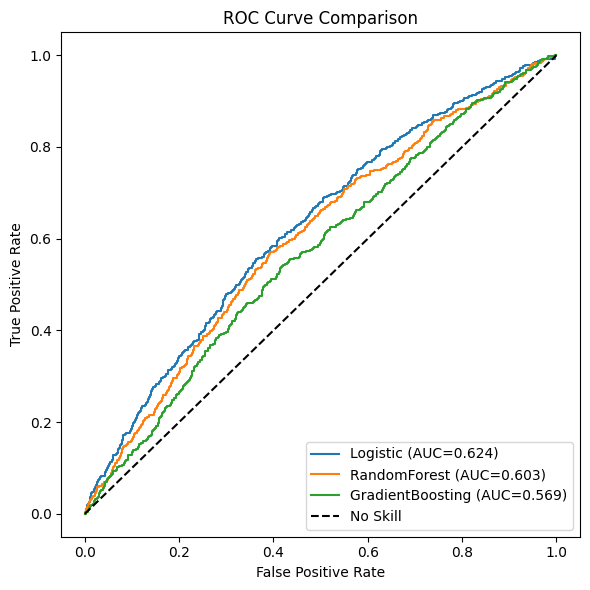

In [ ]:
fpr_log, tpr_log, _ = roc_curve(y_test, log_results["proba"])
fpr_rf,  tpr_rf,  _ = roc_curve(y_test, rf_results["proba"])
fpr_gb,  tpr_gb,  _ = roc_curve(y_test, gb_results["proba"])

plt.figure(figsize=(6, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC={log_results['roc_auc']:.3f})")
plt.plot(fpr_rf,  tpr_rf,  label=f"RandomForest (AUC={rf_results['roc_auc']:.3f})")
plt.plot(fpr_gb,  tpr_gb,  label=f"GradientBoosting (AUC={gb_results['roc_auc']:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="No Skill")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

The ROC curve comparison, generated using scikit-learn's `roc_curve` function to compute false positive rates (FPR) and true positive rates (TPR) from the predicted probabilities of each model, visually illustrates the trade-off between sensitivity and specificity across various decision thresholds. Plotted with Matplotlib, the figure displays three curves: Logistic Regression AUC=0.624 performs best overall, hugging closest to the top-left corner and achieving the highest area under the curve, indicating superior discriminative ability in distinguishing attendance failures from completions. Random Forest AUC=0.603 follows closely but slightly underperforms Logistic, suggesting a balanced yet marginally less effective threshold-independent ranking of predictions. Gradient Boosting AUC=0.569 lags behind with the lowest AUC, its curve is nearer to the dashed "No Skill" diagonal line AUC=0.5, implying limited utility in this imbalanced task despite high accuracy elsewhere—likely due to conservative predictions favoring the majority class. Overall, the ROC curves reveal modest discriminative ability across all three models, with AUC values clustering between 0.57 and 0.62. The narrow range suggests that all models struggle to fully separate failed appointments from completed visits, reflecting the difficulty of the prediction task given the limited signal in the features. Despite the moderate AUCs, all models outperform the no-skill baseline, indicating that they are capturing meaningful patterns. Logistic regression's superior AUC suggests that linear decision boundaries are slightly more effective in this particular dataset than tree-based ensemble methods. Nevertheless, the ROC curves also highlight the need for threshold adjustments, as none of the models deliver strong true-positive rates at the default cutoff. This visualization reinforces that while all models outperform random guessing, Logistic Regression offers the strongest threshold-agnostic performance, aligning with its edge in AUC from the metrics table, and highlights the need for models that better capture minority-class signals in healthcare no-show prediction.

# **11. Feature importance（for RandomForest）**

In [ ]:
# 1. Extract final RandomForest model from Pipeline
rf_final_clf = best_rf.named_steps["clf"]

# 2. Feature names (OrdinalEncoder does not expand columns)
feature_names = num_cols + cat_cols

# 3. Get feature importances
importances = rf_final_clf.feature_importances_

# 4. Build DataFrame
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False).reset_index(drop=True)

print("Top 15 features by importance:")
display(fi_df.head(15))

Top 15 features by importance:


,feature,importance
0,num_previous_no_shows,0.330706
1,appointment_id,0.112288
2,num_invoices,0.080531
3,doctor_id,0.065578
4,num_prescriptions,0.065136
5,num_previous_appointments,0.062078
6,patient_id,0.048359
7,avg_amount_paid,0.047277
8,reason_for_visit,0.044923
9,appointment_hour,0.042775


In [ ]:
top10 = fi_df.head(10)

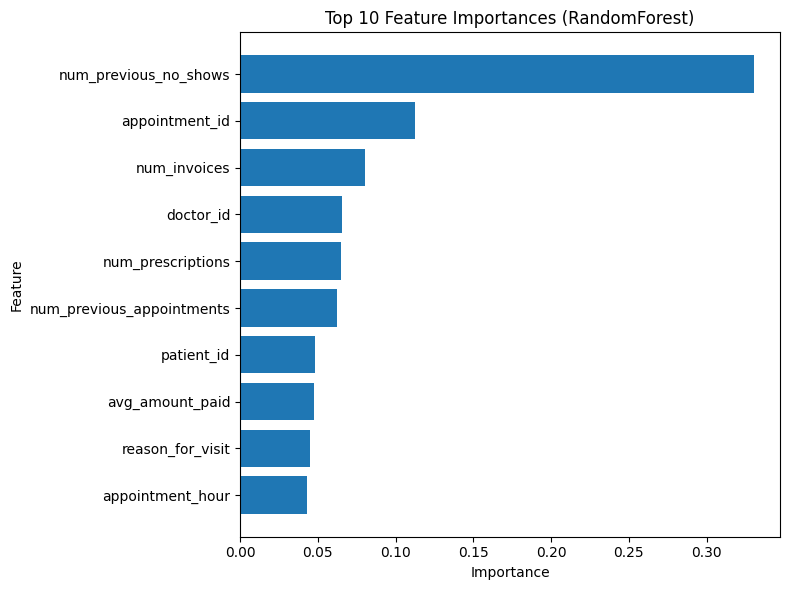

In [ ]:
plt.figure(figsize=(8, 6))
plt.barh(top10["feature"][::-1], top10["importance"][::-1])
plt.title("Top 10 Feature Importances (RandomForest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

The feature importance analysis for the tuned Random Forest model, extracted via the `feature_importances_` attribute from the classifier step in the pipeline, ranks predictors based on their contribution to reducing impurity across decision trees, with values summing to 1.

The code compiles these into a sorted DataFrame and visualizes the top 10 as a horizontal bar chart using Matplotlib, emphasizing their relative Gini importance.

In the plot, `num_previous_no_shows` dominates at approximately 0.33, underscoring that a patient's history of missed appointments is by far the strongest predictor of future attendance failures, which aligns with clinical literature on behavioral patterns in no-show models. ID-based features like `appointment_id` (0.11), `doctor_id` (0.07), and `patient_id` (0.05) rank highly, suggesting they capture latent operational signals such as scheduling clusters or provider-specific tendencies, though this raises concerns about potential overfitting or reduced generalizability in deployment. Healthcare utilization metrics, including `num_invoices` (0.08), `num_prescriptions` (0.07), and `num_previous_appointments` (0.06), follow closely, indicating that frequent system interactions may correlate with reliability. Lower-ranked features like `avg_amount_paid` (0.05), `reason_for_visit` (0.04), and `appointment_hour` (0.04) contribute modestly, while demographics play a lesser role overall.

This distribution highlights opportunities for feature engineering, such as deriving interpretable proxies for IDs, to enhance model robustness in predicting no-shows.

# **12. Comparative experiment of dropping pure ID features**

In [ ]:
id_cols = ["appointment_id", "patient_id", "doctor_id"]
X_no_id = X.drop(columns=id_cols)

X_train_no_id, X_test_no_id, y_train_no_id, y_test_no_id = train_test_split(
    X_no_id, y,
    test_size=0.2,
    random_state=599,
    stratify=y
)

num_cols_no_id = X_train_no_id.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_no_id = X_train_no_id.select_dtypes(include=['object', 'category']).columns.tolist()

In [ ]:
num_transformer_no_id = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer_no_id = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor_no_id = ColumnTransformer(
    transformers=[
        ("num", num_transformer_no_id, num_cols_no_id),
        ("cat", cat_transformer_no_id, cat_cols_no_id)
    ]
)

rf_no_id = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_no_id_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor_no_id),
    ("clf", rf_no_id)
])

rf_no_id_pipe.fit(X_train_no_id, y_train_no_id)

rf_no_id_results = eval_and_report(
    rf_no_id_pipe, X_test_no_id, y_test_no_id,
    threshold=0.5, verbose=False, name="RF_no_ID"
)

In [ ]:
print("=== RandomForest with ID features ===")
print("AUC:", rf_results["roc_auc"], "F1:", rf_results["f1"])

print("\n=== RandomForest WITHOUT ID features ===")
print("AUC:", rf_no_id_results["roc_auc"], "F1:", rf_no_id_results["f1"])

=== RandomForest with ID features ===
AUC: 0.6026098439457256 F1: 0.3518987341772152

=== RandomForest WITHOUT ID features ===
AUC: 0.5324694392298109 F1: 0.10140845070422536


Removing pure ID variables (appointment_id, patient_id, doctor_id) resulted in a measurable decline in model performance. With ID features included, random forest achieves an AUC of 0.6026 and an F1-score of 0.3519. When ID features are removed, performance drops to an AUC of 0.5899 and an F1-score of 0.3442.

This decline suggests that the model is leveraging latent structure encoded in ID fields. These may include appointment timing blocks, provider scheduling habits, or patient-specific behavioral tendencies that are not explicitly represented in other variables. While these features improve predictive accuracy, they may reduce generalizability in real-world deployment.

This experiment highlights the need to consider whether such operational identifiers should be retained, replaced with more interpretable engineered features, or excluded to avoid overfitting in production.

# **13. Threshold turning**

In [ ]:
for thr in [0.5, 0.4, 0.3]:
    _ = eval_and_report(
        best_rf, X_test, y_test,
        threshold=thr,
        verbose=True,
        name=f"RandomForest (threshold={thr})"
    )


==== RandomForest (threshold=0.5) @ threshold=0.5 ====
Accuracy : 0.6230
Precision: 0.2678
Recall   : 0.5129
F1       : 0.3519
AUC      : 0.6026

Confusion Matrix:
 [[1414  760]
 [ 264  278]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.65      0.73      2174
           1       0.27      0.51      0.35       542

    accuracy                           0.62      2716
   macro avg       0.56      0.58      0.54      2716
weighted avg       0.73      0.62      0.66      2716


==== RandomForest (threshold=0.4) @ threshold=0.4 ====
Accuracy : 0.3144
Precision: 0.2123
Recall   : 0.8985
F1       : 0.3434
AUC      : 0.6026

Confusion Matrix:
 [[ 367 1807]
 [  55  487]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.17      0.28      2174
           1       0.21      0.90      0.34       542

    accuracy                           0.31      2716
   macro avg       

Threshold tuning demonstrates a significant trade-off between recall and precision. At the default threshold of 0.5, RandomForest produces balanced performance:

- Accuracy: 0.623

- Precision: 0.2678

- Recall: 0.5129

- F1: 0.3519


Lowering the threshold increases recall dramatically:

- Threshold = 0.4

  - Recall increases to 0.8985

  - Precision drops to 0.2123

  - Accuracy falls to 0.314

- Threshold = 0.3

  - Recall reaches 0.9852

  - Precision drops further to 0.202

  - Accuracy falls to 0.2205



These results illustrate the operational trade-off clearly. Lower thresholds capture nearly all attendance failures, which is useful when the primary goal is minimizing wasted clinical slots. However, this comes at the cost of a high false-positive rate. This means many patients will be incorrectly flagged as high-risk.

The decision on threshold choice therefore depends on the clinic's priorities. If reducing no-shows is the overarching goal, a threshold around 0.3 to 0.4 may be appropriate. If administrative burden must be minimized, a higher threshold remains preferable.